In [1]:
import os
import shutil
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization
from sklearn.model_selection import KFold, StratifiedKFold,train_test_split
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
tfhub_handle_preprocess=r"C:\Users\iavta\Natural Language Processing\BERT\Preprocessing\bert_en_uncased_preprocess_3"
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
tfhub_handle_encoder=r"C:\Users\iavta\Natural Language Processing\BERT\Encoder\small_bert_bert_en_uncased_L-2_H-128_A-2_2"
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [3]:
path=r"C:\Users\iavta\Natural Language Processing\Economics\FED\\"
df_Fed_merged=pd.read_csv(path+"Data - Clean\\"+"Fed_merged.csv")
corpus=df_Fed_merged["text"]
corpus.shape

(855,)

In [201]:
labels=np.asarray(df_Fed_merged["Classes"].astype("int"))
labels.shape

(855,)

In [ ]:
#from sklearn.model_selection import TimeSeriesSplit

The following function is for validation to respect the time series nature of the data.
[0,...,i] -> train indexes, [i+1,...,n-1]->test indexes.

In the future, I'm thinking of augmenting the capabilities to cross-validation.
It would return increasing sequential indexes for the train samples [0,...,i], [0,...,i+1], [0,...,i+2], and so on. And the complement for the test samples.

In [61]:
def Time_Validation(corpus,labels,test_size=0.2):
       
    train_index = list(range(int(len(corpus)-np.floor(test_size*len(corpus))+1)))
    
    
    test_index =list(range(int(len(corpus)-np.floor(test_size*len(corpus))+1),len(corpus)))
    
    
    return corpus[train_index], corpus[test_index],labels[train_index], labels[test_index]

# BERT - Small Model - Classification

Below is the plot function, we'll be using.

In [82]:
import seaborn as sns

sns.set()

def print_plots(history):
    history_dict = history.history
    #print(history_dict.keys())

    acc = history_dict['sparse_categorical_accuracy']
    val_acc = history_dict['val_sparse_categorical_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))#,constrained_layout = True)
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend();

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4);

In [202]:
corpus_train, corpus_test, labels_train, labels_test=Time_Validation(corpus,labels)

In [203]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='sentences')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    # We only want to fine-tune, hence the False input.
    # I've also tried with trainable=True out of curiosity... the results were similar
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [8]:
#corpus_train, corpus_test, labels_train, labels_test = train_test_split(corpus,
#                                                                       labels, test_size=0.33, 
#                                                                       random_state=42)

In [204]:
# we need to cread a tf dataset to work with the BERT model.
# from_tensor_slices either receives an numpy array, or a tuple, or a dictionary
batch_size=1
sentences_train=tf.constant(corpus_train)

train_dataset = tf.data.Dataset.from_tensor_slices(
        (sentences_train,labels_train)
        ).batch(batch_size)

In [205]:
sentences_test=tf.constant(corpus_test)
test_dataset = tf.data.Dataset.from_tensor_slices(
        (sentences_test,labels_test)
        ).batch(batch_size)

In [206]:
classifier_model = build_classifier_model()

In [207]:
classifier_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentences (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           sentences[0][0]                  
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  4385921     preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [208]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy')

In [209]:
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(),
                         loss=loss,
                         metrics=metrics)

In [148]:
epochs = 10
history = classifier_model.fit(x=train_dataset,
                               validation_data=test_dataset,
                               epochs=epochs,verbose=1)

Epoch 1/10
685/685 [==============================] - 89s 119ms/step - loss: 1.0677 - sparse_categorical_accuracy: 0.4350 - val_loss: 1.0482 - val_sparse_categorical_accuracy: 0.4471
Epoch 2/10
685/685 [==============================] - 84s 120ms/step - loss: 1.0752 - sparse_categorical_accuracy: 0.4409 - val_loss: 1.0498 - val_sparse_categorical_accuracy: 0.4471
Epoch 3/10
685/685 [==============================] - 84s 120ms/step - loss: 1.0442 - sparse_categorical_accuracy: 0.4628 - val_loss: 1.0389 - val_sparse_categorical_accuracy: 0.4706
Epoch 4/10
685/685 [==============================] - 81s 117ms/step - loss: 1.0310 - sparse_categorical_accuracy: 0.4526 - val_loss: 1.0386 - val_sparse_categorical_accuracy: 0.4882
Epoch 5/10
685/685 [==============================] - 88s 125ms/step - loss: 1.0289 - sparse_categorical_accuracy: 0.4759 - val_loss: 1.0410 - val_sparse_categorical_accuracy: 0.4647
Epoch 6/10
685/685 [==============================] - 86s 123ms/step - loss: 1.0278 -

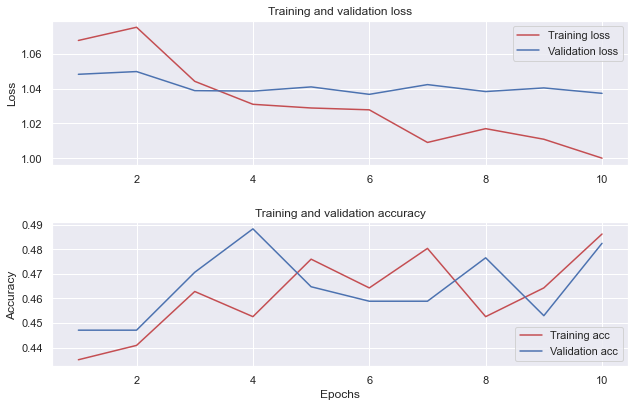

In [149]:
print_plots(history)

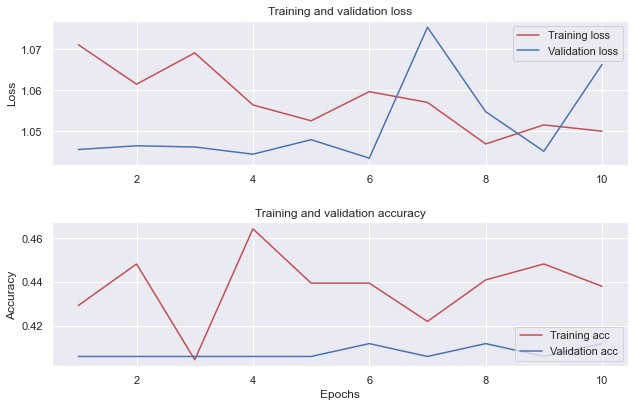

In [83]:
#This was from a previous run, with trainable = True
#print_plots(history)

Using trainable = False seems to allows us to take advantage of pre-training, given the small amount of data.

In [210]:
epochs = 20
history20 = classifier_model.fit(x=train_dataset,
                               validation_data=test_dataset,
                               epochs=epochs,verbose=1)

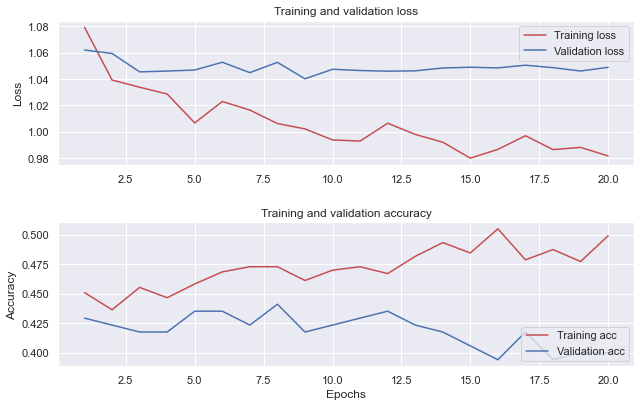

In [211]:
print_plots(history20)

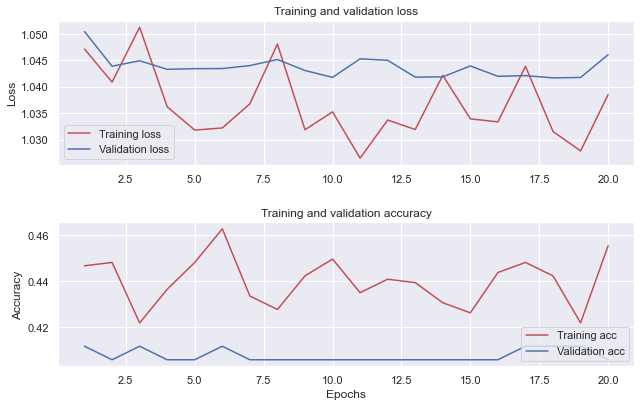

In [85]:
#This was from a previous run, with trainable = True
#print_plots(history20)

In [212]:
path_saved_bert=path+"Saved Models\\"+"BERT - Small - Classification"

In [213]:
classifier_model.save(path_saved_bert, include_optimizer=False)

To reload, without retraining, uncomment and run the following cell:

In [89]:
reloaded_model = tf.saved_model.load(path_saved_bert)

In [199]:
def print_my_examples(inputs, results,version="classifier"):
    if version=="classifier":        
        message="input: {0} class: {1} score: {2}"
        result_for_printing = [message.format(inputs[i][0:50],
                                                  np.where(results.numpy()[i] == np.amax(results.numpy()[i]))[0],
                                                  np.amax(results.numpy()[i]))
                               for i in range(len(inputs))]
        print(*result_for_printing, sep='\n')
    if version=="regressor":
        message="input: {0} target: {1}"
        result_for_printing = [message.format(inputs[i][0:50],results.numpy()[i][0])
                               for i in range(len(inputs))]
        print(*result_for_printing, sep='\n')
    
    print()

In [140]:
examples = [
    'Trust us, inflation will be 2%', 
    'We are unsure whether it will be 2%',
    'Inflation will be higher than 2%',
    'Inflation will be lower than 2%',
]

In [214]:
results=tf.nn.softmax(classifier_model(tf.constant(examples)))
print_my_examples(examples,results)
# 0 ->  no change
# 2 -> increased the distance relative to objective of 2
# 1 -> decreased the distance relative to objective of 2

input: Trust us, inflation will be 2% class: [2] score: 0.3560473620891571
input: We are unsure whether it will be 2% class: [1] score: 0.3691926598548889
input: Inflation will be higher than 2% class: [2] score: 0.36230242252349854
input: Inflation will be lower than 2% class: [2] score: 0.36345064640045166



The model doesn't seem to be strong enough to detect anything... =D

# BERT - Small Model - Regression

In [179]:
def print_plots_regression(history):
    history_dict = history.history
    #print(history_dict.keys())

    acc = history_dict['mean_squared_error']
    val_acc = history_dict['val_mean_squared_error']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))#,constrained_layout = True)
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend();

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training Error')
    plt.plot(epochs, val_acc, 'b', label='Validation Error')
    plt.title('Training and validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4);

In [157]:
def build_regression_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='sentences')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    #net = tf.keras.layers.Dropout(0.1)(net)
    # no activation function, and just 1 output, since we're interested in Regression
    net = tf.keras.layers.Dense(1, name='regressor')(net)
    return tf.keras.Model(text_input, net)

For regression, we'll use as a target variable the (continuous variable) T5YIFR

In [159]:
df_Fed_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 855 non-null    object 
 1   link                 855 non-null    object 
 2   title                855 non-null    object 
 3   event                855 non-null    object 
 4   text                 855 non-null    object 
 5   location             855 non-null    object 
 6   DATE                 855 non-null    object 
 7   T5YIFR               855 non-null    float64
 8   Changes of T5YIFR    855 non-null    float64
 9   Distance to 2        855 non-null    float64
 10  Changes in Distance  855 non-null    float64
 11  Classes              855 non-null    float64
dtypes: float64(5), object(7)
memory usage: 80.3+ KB


In [161]:
target=np.asarray(df_Fed_merged["T5YIFR"])
target.shape

(855,)

In [162]:
corpus_train, corpus_test, target_train, target_test=Time_Validation(corpus,target)

In [163]:
#batch_size=1
#sentences_train=tf.constant(corpus_train)

train_dataset = tf.data.Dataset.from_tensor_slices(
        (sentences_train,target_train)
        ).batch(batch_size)

In [164]:
#sentences_test=tf.constant(corpus_test)

test_dataset = tf.data.Dataset.from_tensor_slices(
        (sentences_test,target_test)
        ).batch(batch_size)

In [158]:
regression_model = build_regression_model()

In [165]:
regression_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentences (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           sentences[0][0]                  
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  4385921     preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [166]:
loss = tf.keras.losses.MeanSquaredError() # we could also have used the MAE
metrics = tf.keras.metrics.MeanSquaredError()

In [167]:
regression_model.compile(optimizer=tf.keras.optimizers.Adam(),
                         loss=loss,
                         metrics=metrics)

In [175]:
epochs = 20
history_regression = regression_model.fit(x=train_dataset,
                               validation_data=test_dataset,
                               epochs=epochs,verbose=1)

Epoch 1/20
685/685 [==============================] - 88s 127ms/step - loss: 0.0764 - mean_squared_error: 0.0764 - val_loss: 0.1699 - val_mean_squared_error: 0.1699
Epoch 2/20
685/685 [==============================] - 94s 133ms/step - loss: 0.0706 - mean_squared_error: 0.0706 - val_loss: 0.1499 - val_mean_squared_error: 0.1499
Epoch 3/20
685/685 [==============================] - 88s 126ms/step - loss: 0.0671 - mean_squared_error: 0.0671 - val_loss: 0.1383 - val_mean_squared_error: 0.1383
Epoch 4/20
685/685 [==============================] - 86s 124ms/step - loss: 0.0647 - mean_squared_error: 0.0647 - val_loss: 0.1316 - val_mean_squared_error: 0.1316
Epoch 5/20
685/685 [==============================] - 91s 130ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.1275 - val_mean_squared_error: 0.1275
Epoch 6/20
685/685 [==============================] - 93s 132ms/step - loss: 0.0615 - mean_squared_error: 0.0615 - val_loss: 0.1250 - val_mean_squared_error: 0.1250
Epoch 7/20

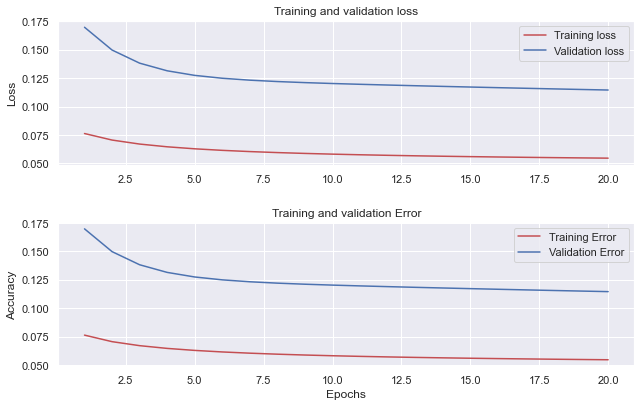

In [180]:
print_plots_regression(history_regression)

This shows that the model is underfitting.

In [200]:
results=regression_model(tf.constant(examples))
print_my_examples(examples,results,"regressor")

input: Trust us, inflation will be 2% target: 1.7539467811584473
input: We are unsure whether it will be 2% target: 1.5696932077407837
input: Inflation will be higher than 2% target: 1.7546751499176025
input: Inflation will be lower than 2% target: 1.717501163482666



Here, even though the differences don't seem to be substancial, they are in the right sense. 

In [215]:
path_saved_bert=path+"Saved Models\\"+"BERT - Small - Regression"
regression_model.save(path_saved_bert, include_optimizer=False)